In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import scipy.io
import math
import sklearn
import sklearn.datasets
from PIL import Image
from scipy import ndimage
from op_utils import initialize_params, forward_prop, cost_fun, backward_prop
from op_utils import *

%matplotlib inline

In [2]:
# 梯度下降
def update_grad_gd(params, grads, learning_rate):
    L = len(params) // 2
    for l in range(L):
        params["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        params["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
    
    return params

In [3]:
# 动量法 momentum
def initialize_momentum(params):
    L = len(params) // 2
    V = {}
    # initialize
    for l in range(L):
        V["W" + str(l+1)] = np.zeros((params["W" + str(l+1)].shape[0], params["W" + str(l+1)].shape[1]))
        V["b" + str(l+1)] = np.zeros((params["b" + str(l+1)].shape[0], params["b" + str(l+1)].shape[1]))
        
    return V
    
def update_grad_momentum(params, grads, V, beta, t, learning_rate):
    L = len(params) // 2
    for l in range(L):
        V["W" + str(l+1)] = beta * V["W" + str(l+1)] + (1 - beta) * grads["dW" + str(l+1)]
        V["b" + str(l+1)] = beta * V["b" + str(l+1)] + (1 - beta) * grads["db" + str(l+1)]
        
        corr_V_W = V["W" + str(l+1)] / (1 + np.power(beta, t))
        corr_V_b = V["b" + str(l+1)] / (1 + np.power(beta, t))
        
        params["W" + str(l+1)] -= learning_rate * corr_V_W
        params["b" + str(l+1)] -= learning_rate * corr_V_b
    
    return params, V

# def update_grad_momentum(params, grads, beta = 0.9, t, learning_rate):
#     L = len(params) // 2
#     V_dW_pre = 0
#     V_db_pre = 0
#     for l in range(L):
#         V_dW = beta * V_dW_pre + (1 - beta) * grads["dW" + str(l+1)]
#         V_db = beta * V_db_pre + (1 - beta) * grads["db" + str(l+1)]   
        
#         V_dW_pre = V_dW
#         V_db_pre = V_db
        
#         corr_V_dW = V_dW / (1 + np.power(beta, t))
#         corr_V_db = V_db / (1 + np.power(beta, t))
        
#         params["W" + str(l+1)] -= learning_rate * corr_V_dW
#         params["b" + str(l+1)] -= learning_rate * corr_V_db
    
#     return params

# def update_grad_momentum(params, grads, beta = 0.9, t, learning_rate):
#     L = len(params) // 2
#     V_dW = 0
#     V_db = 0
#     for l in range(L):
#         V_dW = beta * V_dW + (1 - beta) * grads["dW" + str(l+1)]
#         V_db = beta * V_db + (1 - beta) * grads["db" + str(l+1)]   
        
#         corr_V_dW = V_dW / (1 + np.power(beta, t))
#         corr_V_db = V_db / (1 + np.power(beta, t))
        
#         params["W" + str(l+1)] -= learning_rate * corr_V_dW
#         params["b" + str(l+1)] -= learning_rate * corr_V_db
    
#     return params

# a = np.ones((3,2))
# print(a)
# b = 1 + a 
# print(b)
# c= b + a
# print(c)

In [4]:
# RMSprop
def initialize_RMSprop(params):
    L = len(params) // 2
    S = {}
    # initialize
    for l in range(L):
        S["W" + str(l+1)] = np.zeros((params["W" + str(l+1)].shape[0], params["W" + str(l+1)].shape[1]))
        S["b" + str(l+1)] = np.zeros((params["b" + str(l+1)].shape[0], params["b" + str(l+1)].shape[1]))
        
    return S

def update_grad_RMSprop(params, grads, S, beta, epsilon, t, learning_rate):
    L = len(params) // 2
    for l in range(L):
        S["W" + str(l+1)] = beta * S["W" + str(l+1)] + (1 - beta) * np.square(grads["dW" + str(l+1)])
        S["b" + str(l+1)] = beta * S["b" + str(l+1)] + (1 - beta) * np.square(grads["db" + str(l+1)])
        
        corr_S_W = S["W" + str(l+1)] / (1 + np.power(beta, t))
        corr_S_b = S["b" + str(l+1)] / (1 + np.power(beta, t))
        
        params["W" + str(l+1)] -= learning_rate * (grads["dW" + str(l+1)] / (np.sqrt(corr_S_W) + epsilon))
        params["b" + str(l+1)] -= learning_rate * (grads["db" + str(l+1)] / (np.sqrt(corr_S_b) + epsilon))
        
    return params, S

In [5]:
# Adam
def initialize_Adam(params):
    L = len(params) // 2
    V = {}
    S = {}
    # initialize
    for l in range(L):
        V["W" + str(l+1)] = np.zeros((params["W" + str(l+1)].shape[0], params["W" + str(l+1)].shape[1]))
        V["b" + str(l+1)] = np.zeros((params["b" + str(l+1)].shape[0], params["b" + str(l+1)].shape[1]))
        
        S["W" + str(l+1)] = np.zeros((params["W" + str(l+1)].shape[0], params["W" + str(l+1)].shape[1]))
        S["b" + str(l+1)] = np.zeros((params["b" + str(l+1)].shape[0], params["b" + str(l+1)].shape[1]))
        
    return V, S

def update_grad_Adam(params, grads, V, S, beta1, beta2, epsilon, t, learning_rate):
    L = len(params) // 2
    for l in range(L):
        V["W" + str(l+1)] = beta1 * V["W" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]
        V["b" + str(l+1)] = beta1 * V["b" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]
        
        corr_V_W = V["W" + str(l+1)] / (1 + np.power(beta1, t))
        corr_V_b = V["b" + str(l+1)] / (1 + np.power(beta1, t))
        
        S["W" + str(l+1)] = beta2 * S["W" + str(l+1)] + (1 - beta2) * np.square(grads["dW" + str(l+1)])
        S["b" + str(l+1)] = beta2 * S["b" + str(l+1)] + (1 - beta2) * np.square(grads["db" + str(l+1)])
        
        corr_S_W = S["W" + str(l+1)] / (1 + np.power(beta2, t))
        corr_S_b = S["b" + str(l+1)] / (1 + np.power(beta2, t))
        
        params["W" + str(l+1)] -= learning_rate * (corr_V_W / (np.sqrt(corr_S_W) + epsilon))
        params["b" + str(l+1)] -= learning_rate * (corr_V_b / (np.sqrt(corr_S_b) + epsilon))
    
    return params, V, S

In [6]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : :]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : :]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [7]:
# 定义模型_随机梯度下降（SGD）_mini_batch梯度下降
def model(X, Y, layer_dims, beta1 = 0.9, beta2 = 0.99, epsilon = 1e-8, 
          batch_size = 64, num_itera = 3000, learning_rate = 0.0075, 
          lambd = 0, keep_prop = 1, opt = 'Adam', print_cost = True):
    m = X.shape[1]
    L = len(layer_dims)
    params = initialize_params(layer_dims)
    if opt == 'gd':
        pass
    elif opt == 'momentum':
        V = initialize_momentum(params)
    elif opt == "RMSprop":
        S = initialize_RMSprop(params)
    elif opt == "Adam":
        V, S = initialize_Adam(params)
    costs = []
    '''
    # SGD
    for i in range(num_itera):
        for j in range(m):
            X = X[:, j]
            Y = Y[:, j]
            AL, caches = forward_prop(X, params)
            cost = cost_fun(AL, Y)
            grads = backward_prop(params, caches, Y)
            if opt == 'gd':
                params = update_grad_gd(params, grads, learning_rate)
            elif opt == 'momentum':
                params = update_grad_momentum(params, grads, beta1, i+1, learning_rate)
            elif opt == "RMSprop":
                params = update_grad_RMSprop(params, grads, beta2, epsilon, i+1, learning_rate)
            elif opt == "Adam":
                params = update_grad_Adam(params, grads, beta1, beta2, epsilon, i+1, learning_rate)
            
        if print_cost and (i % 100 == 0):
            costs.append(cost)
            print("Cost in iter %i is %f" % (i, cost))
    '''
            
    # mini_batch gradient decent
    mini_batchs = random_mini_batches(X, Y, batch_size)
    for i in range(num_itera):
        for mini_batch in mini_batchs:
            (X, Y) = mini_batch
            AL, caches = forward_prop(X, params)
            reg_cost = 0
            for l in range(1, L):
                reg_cost += np.sum(np.square(params["W" + str(l)]))
            cost = cost_fun(AL, Y) + (lambd/(2*m)) * reg_cost
            grads = backward_prop(params, caches, Y, lambd)
            if opt == 'gd':
                params = update_grad_gd(params, grads, learning_rate)
            elif opt == 'momentum':
                params, V = update_grad_momentum(params, grads, V, beta1, i+1, learning_rate)
            elif opt == "RMSprop":
                params, S = update_grad_RMSprop(params, grads, S, beta2, epsilon, i+1, learning_rate)
            elif opt == "Adam":
                params, V, S = update_grad_Adam(params, grads, V, S, beta1, beta2, epsilon, i+1, learning_rate)
            
        if print_cost and (i % 100 == 0):
#             costs.append(cost)
            print("Cost in iter %i is %f" % (i, cost))
        if i % 100 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 100)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return params    

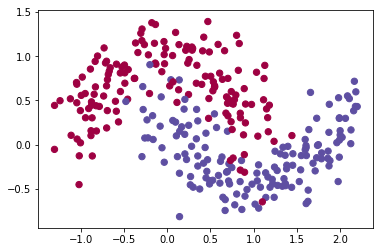

In [8]:
train_X, train_Y = load_dataset()

In [ ]:
# train 3-layer model
layer_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layer_dims, opt = "gd", num_itera = 20000, learning_rate = 0.0009, print_cost = False)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
# plt.title("Model with Gradient Descent optimization")
# axes = plt.gca()
# axes.set_xlim([-1.5,2.5])
# axes.set_ylim([-1,1.5])
# plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

In [ ]:
# train 3-layer model
layer_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layer_dims, opt = "momentum", num_itera = 20000, learning_rate = 0.0009, print_cost = False)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
# plt.title("Model with Momentum optimization")
# axes = plt.gca()
# axes.set_xlim([-1.5,2.5])
# axes.set_ylim([-1,1.5])
# plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

In [ ]:
# train 3-layer model
layer_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layer_dims, opt = "RMSprop", num_itera = 20000, learning_rate = 0.0009,  print_cost = False)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
# plt.title("Model with RMSprop optimization")
# axes = plt.gca()
# axes.set_xlim([-1.5,2.5])
# axes.set_ylim([-1,1.5])
# plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

In [ ]:
# train 3-layer model
layer_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layer_dims, opt = "Adam", num_itera = 20000, learning_rate = 0.0009,  print_cost = False)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
# plt.title("Model with Adam optimization")
# axes = plt.gca()
# axes.set_xlim([-1.5,2.5])
# axes.set_ylim([-1,1.5])
# plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

In [9]:
# 导入数据集
train_x_orig, train_y, test_x_orig, test_y, classes = load_cat_dataset()

y = 0. It's a non-cat picture.


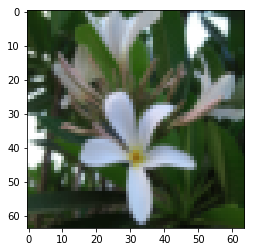

In [10]:
# Example of a picture
index = 9
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [11]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [12]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


Cost in iter 0 is 1.110009
Cost in iter 100 is 0.760763
Cost in iter 200 is 0.563390
Cost in iter 300 is 0.409648
Cost in iter 400 is 0.329324
Cost in iter 500 is 0.339615
Cost in iter 600 is 0.235772
Cost in iter 700 is 0.109493
Cost in iter 800 is 0.102265
Cost in iter 900 is 0.121005
Cost in iter 1000 is 0.096402
Cost in iter 1100 is 0.096931
Cost in iter 1200 is 0.617382
Cost in iter 1300 is 0.093809
Cost in iter 1400 is 0.084384


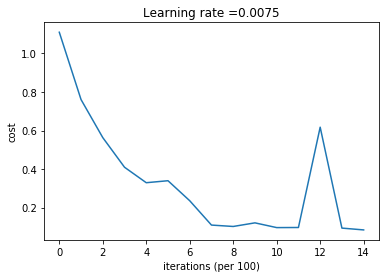

In [87]:
layer_dims = [12288, 20, 7, 5, 1]
params = model(train_x, train_y, layer_dims, opt = "gd", num_itera = 1500, learning_rate = 0.0075, lambd = 3) # early-stop 解决过拟合

In [88]:
pred_train = predict(train_x, train_y, params)

Accuracy is 1.000000


In [89]:
pred_test = predict(test_x, test_y, params)

Accuracy is 0.760000


Accuracy is 1.000000
[[False]]
y = False, your L-layer model predicts a "non-cat" picture.


/media/dyjng/数据A/DL_DYJ/deeplearning.ai/lesson2/week2/op_utils.py:38: RuntimeWarning: overflow encountered in exp
  caches["A" + str(L)] = 1 / (1 + np.exp(-caches["Z" + str(L)]))


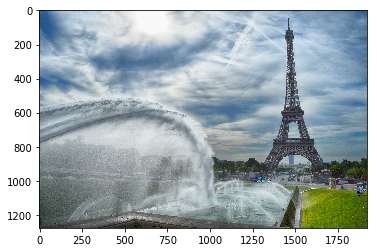

In [94]:
## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [0] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, params)
print(my_predicted_image)
plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")